__앙상블(Emsemble)__ : 일련의 예측기  
__앙상블 학습(Ensemble Learning)__ : 일련의 예측기로부터 예측을 수집해, 더 좋은 예측을 얻는것  
__앙상블 방법(Ensemble Method)__ : 앙상블 학습 알고리즘  
결정 트리의 앙상블을 Random Forest라 한다.

## 7.1 투표 기반 분류기  
__Hard Voting(직접 투표) 분류기__ : 각 분류기의 예측을 모아서 다수결 투표로 정해지는 분류기. 각 분류기가 wak learner라도 충분하게 다양하고 많다면, 앙상블은 strong learner가 될 수 있다. (law of large number 에 의해...)   
같은 종류의 오차를 만들어 잘못된 클래스가 다수일 경우 앙상블의 정확도는 낮아진다. 즉 앙상블 방법은 분류기가 서로 독립적일 때 성능이 좋아진다. 


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         n_jobs=1, voting='hard', weights=None)

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.896


__Soft Voting(간접 투표)__ : 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하는 방식

## 7.2  배깅과 페이스팅  
training set의 subset을 무작위로 구성하여 분류기를 각각 다르게 학습시킬 수 있따. 중복을 허용하여 샘플링하는 경우를 __Bagging(배깅, bootstrap aggregating)__, 중복을 허용하지 않고 샘플링하는 방식을 __pasting(페이스팅)__ 이라 한다.  
앙상블은 모든 예측기의 예측을 모아서 샘플에 대한 새로운 예측을 만든다. 수집함수는 분류일 때는 __통계적 최빈값(statistical mode)__을 회귀일 때는 평균을 계산한다. 개별 예측기는 전체 트레이닝 셋을 훈련시킬 때보다는 편향되어있지만, 수집함수를 통과시킨 후에 편향과 분산은 모두 감소한다.

### 7.2.1 사이킷런의 배깅과 페이스팅

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1) ##n_jobs : CPU 코어수 지정
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [5]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.912


In [6]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [7]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [8]:
def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

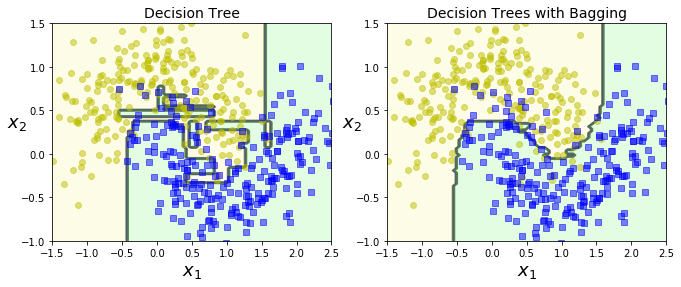

In [9]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

배깅이 페이스팅보다 편향이 조금 더 높지만, 예측기들간의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 일반적으로 배깅이 더 나은 모델을 만드나, 시간과 cpu파워에 여유가 있다면 교차 검증으로 배깅, 페이스팅 모두 평가하는 것이 좋다.

### 7.2.2 oob 평가  
bagging에서 사용되지 않는 훈련샘플을 oob(out-of-bag)샘플이라 한다. 앙상블의 평가는 예측기의 oob평가를 평균하여 얻는다.

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40) #oob_score=True로 지정하면 자동으로 oob평가수행
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90133333333333332

In [12]:
# test_set 확인
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91200000000000003

In [13]:
#oob샘플에 대한 결정 함수의 값은 oob_decision_function_ 변수에서 확인할 수 있다. 이 경우 결정함수는 각 훈련 샘플의 클래스 확률을 반환한다.
bag_clf.oob_decision_function_[:10]

array([[ 0.31746032,  0.68253968],
       [ 0.34117647,  0.65882353],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.08379888,  0.91620112],
       [ 0.31693989,  0.68306011],
       [ 0.02923977,  0.97076023],
       [ 0.97687861,  0.02312139],
       [ 0.97765363,  0.02234637]])

## 7.3  랜덤 패치와 랜덤 서브스페이스
BaggingClassifier는 특성 샘플링도 지원한다. 특성 샘플링은 더 다양한 예측기를 만들며 편향은 늘리지만 분산은 낮춘다.

## 7.4 랜덤 포레스트
배깅 방법을 적용한 결정 트리의 앙상블을 랜덤 포레스트라 한다.

In [16]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜던 포레스트는 무작위로 선택한 특성 후보 중 최적의 특성을 찾는 식으로 무작위성을 더 주입한다. 편향을 높이는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만든다.

In [17]:
#BaggingClassifier 로 RandomForestClassifier와 유사하게 만들 수 있다.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

### 7.4.1 엑스트라 트리
트리를 더욱 무작위하게 만들기 후보 특성을 사용해 무작위로 분할할 후 최상의 분할을 선택하는 극단적으로 무작위한 트리의 랜덤포레스트를 Extremely Randomized Trees앙상블이라한다. 모든 노드에서 특성마다 가장 최적의 임곗갓을 찾는 작업이 없으므로 훨씬 빠르다.

### 7.4.2 특성 중요도
랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉽다. 사이킷런은 훈련이 끝난후 특성의 점수를 자동으로 계산해 전체 중요도합이 1이 되도록 정규화한다.

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [19]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

## 7.5 부스팅
앞의 모델을 보완해가며 일련의 예측기를 학습시키는 앙상블 방법으로 __AdaBoost, GradientBoosting__ 등이 있다.

### 7.5.1 아다부스트
이전 모델이 과소 적합했던 훈련 샘플의 가중치를 높여, 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 한다. 다음 예측기에서 잘못 분류된 샘플들은 가중치를 높이고, 학습률을 낮춰가며 학습한다.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

In [ ]:
plot_decision_boundary(ada_clf, X, y)

In [ ]:
m = len(X_train)
plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

#save_fig("boosting_plot")
plt.show()
#왼쪽: 가중치 2의배수로 증가 . #오른쪽 : 가중치 1.5배씩 증가

각 샘플 가중치 $w^{(i)}$ 는 $\frac{1}{m}$이다. 예측기가 학습된 후, j번째 가중치가 적용된 에러율 $r_j$는 ($\hat{y}$=$y$인 $w^{i}$의 합)/($w^{i}$의 합)이다.

예측기의 가중치 ${\alpha}_j = \eta\log{\frac{1-r_j}{r_j}}$ 이다.  
$\eta$ 는 학습률 파라미터

가중치 업데이트 규칙은 다음과 같다.  
$\hat{y_j}^{(i)}=y^{(i)}$일 때 $w^{(i)} \leftarrow w^{(i)}$  
$\hat{y_j}^{(i)} \neq y^{(i)}$일 때 $w^{(i)} \leftarrow w^{(i)}exp(\alpha_j)$

모든 샘플의 가중치를 정규화한 후, 새 예측기가 이 가중치를 사용해 훈련되고 전체 과정이 반복된다.  
아다부스트는 모든 예측기의 예측을 계산한 후 가중치 $\alpha_j$를 더해 예측 결과를 만든다.  
$\hat{y}=\underset{k}{argmax}\sum_{\underset{\hat{y}_j(x)=k}{i=1}}^N \alpha_j$

사이킷런은 SAMME라는 아다부스트의 다중 클래스 버전을 사용하고, 예측기가 클래스 확률을 추정할 수 있따면, SAMME.R을 사용한다.

### 7.5.2 그래디언트 부스팅
이전 예측기가 만든 잔여 오차 residual error에 새로운 예측귀를 학습시킨다. decision tree를 기반 예측기로 사용할 경우 __Gradient Tree Boosting__ 또는 __Gradient Boosted Regression Tree__라고 한다.

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

In [ ]:
# 첫번째 예측기에서 생긴 잔여 오차에 두번째 DecisionTreeRegressor를 훈련시킨다.
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

In [ ]:
# 두번째 예측기에서 생긴 잔여 오차에 세번째 DecisionTreeRegressor를 훈련시킨다.
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

In [ ]:
# 모든 트리의 예측을 더해서 새로운 샘플에 대한 예측을 구한다.
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()


In [ ]:
# 사이킷런에서 GradientBoostingRegressor를 지원한다.
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

learning rate가 각 트리의 기여정도를 조절한다. learning rate를 낮게 설정할 경우 많은 트리가 필요하지만 예측성능은 좋아진다. 이를 __shrinkage축소__라고 한다.

In [ ]:
gbrt_underfit = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt_underfit.fit(X, y)
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt_underfit], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

#save_fig("gbrt_learning_rate_plot")
plt.show()

__Early stopping__

In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

In [ ]:
min_error = np.min(errors)

In [ ]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

#save_fig("early_stopping_gbrt_plot")
plt.show()

실제로 훈련을 중지하는 조기 종료를 구현할 수도 있따. warm_start=True로 설정하면, fit() 메서드가 호출될 떄 기존 트리를 유지하고 훈련을 추가할 수 있다.

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

subsample 파라미터를 조절하여 무작위로 선택된 훈련샘플로 GradientBoostingRegressor를 학습시킬 수 있다. 이를 __확률적 그래디언트 부스팅__이라고 한다.

## 7.6 스태킹 Staking
마지막 예측기(blender 또는 meta learner)가 예측을 입력으로 받아 최종 예측을 만드는 방식. out-of-fold 예측을 사용하는 경우 __스태킹__이라 하고, hold-out set를 사용할 때는 __블랜딩__이라한다. 그러나 보통 혼용되어 사용한다.